## In this notebook, we show a classification example using the employee dataset. In this example, the target variable is "doubling_salary" that shows if an employee would have a double or more salary. This binary target variable is equal to one when salary is doubled and zero otherwise. 

## The explanatory variables include age, edu, jobtime, prevexp, minority, gender, and jobcat. Definition of these explanatory variables is presented below. 

## Here we compare the results found by two packages: safeaipackage and modelagnosticsafeaipackage


In [3]:
import pandas as pd
import numpy as np
import warnings
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier


##safeaipackage
from safeaipackage import check_accuracy as accuracy
from safeaipackage import check_explainability as explainability
from safeaipackage import check_fairness as fairness
from safeaipackage import check_privacy as privacy
from safeaipackage import check_robustness as robustness


##modelagnosticsafeaipackage
from modelagnosticsafeaipackage import check_accuracy as modelagnostic_accuracy
from modelagnosticsafeaipackage import check_explainability as modelagnostic_explainability
from modelagnosticsafeaipackage import check_fairness as modelagnostic_fairness
from modelagnosticsafeaipackage import check_privacy as modelagnostic_privacy
from modelagnosticsafeaipackage import check_robustness as modelagnostic_robustness


warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 10000)

In [4]:
data = pd.read_excel("employee.xlsx")
print("This dataset has {} rows and {} columns".format(data.shape[0], data.shape[1]))
data.head()

This dataset has 473 rows and 9 columns


,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat
0,57000,36,15,27000,98,144,no_min,m,manager
1,40200,30,16,18750,98,36,no_min,m,Clerical
2,21450,59,12,12000,98,381,no_min,f,Clerical
3,21900,41,8,13200,98,190,no_min,f,Clerical
4,45000,33,15,21000,98,138,no_min,m,Clerical


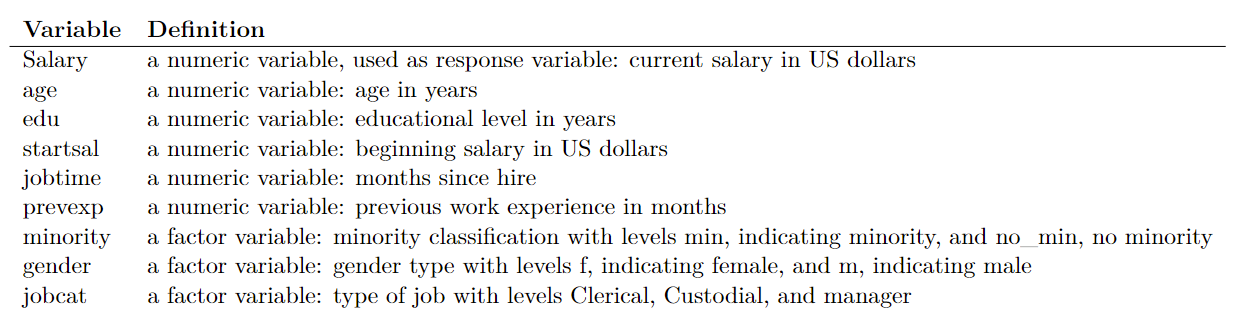

In [5]:
data["gender"] = np.where(data["gender"]=="m", 0, 1)
data["minority"] = np.where(data["minority"]=="no_min", 0, 1)
data = pd.get_dummies(data, columns=["jobcat"])
data.head()

,salary,age,edu,startsal,jobtime,prevexp,minority,gender,jobcat_Clerical,jobcat_Custodial,jobcat_manager
0,57000,36,15,27000,98,144,0,0,0,0,1
1,40200,30,16,18750,98,36,0,0,1,0,0
2,21450,59,12,12000,98,381,0,1,1,0,0
3,21900,41,8,13200,98,190,0,1,1,0,0
4,45000,33,15,21000,98,138,0,0,1,0,0


In [6]:
data["doubling_salary"] = np.where(data["salary"]/data["startsal"] > 2,1,0)

data["doubling_salary"].value_counts()

0    253
1    220
Name: doubling_salary, dtype: int64

In [7]:
X = data.drop(["doubling_salary", "salary", "startsal"], axis=1)
y = data["doubling_salary"]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=1)

print(xtrain.shape)
print(xtest.shape)

(331, 9)
(142, 9)


# ACCURACY

In [8]:
accuracy_obj = accuracy.Accuracy(xtrain, xtest, ytrain, ytest, RandomForestClassifier(random_state=1))

In [9]:
accuracy_obj.rga()

0.6848958333333334

In [10]:
model = RandomForestClassifier(random_state=1).fit(xtrain, ytrain)
yhat = model.predict(xtest)
rga_modelagnostic = modelagnostic_accuracy.rga(ytest, yhat)

rga_modelagnostic

0.6848958333333334

### In the following command, since the input "variable" is given, the test is done to compare the predictive accuracy of the full Random Forest model with that of a reduced Random Forest model without "age"

In [11]:
accuracy_obj.rga_statistic_test("classification", "age")

0.4257515747103916

In [12]:
xtrain_rm = xtrain.drop("age", axis=1)
xtest_rm = xtest.drop("age", axis=1)
model_rm = RandomForestClassifier(random_state=1).fit(xtrain_rm, ytrain)
yhat_rm = model_rm.predict(xtest_rm)
modelagnostic_accuracy.rga_statistic_test(ytest, yhat_rm, yhat)

0.4257515747103915

# EXPLAINABILITY

In [13]:
explainability_obj = explainability.Explainability(xtrain, xtest, ytrain, ytest, RandomForestClassifier(random_state=1))

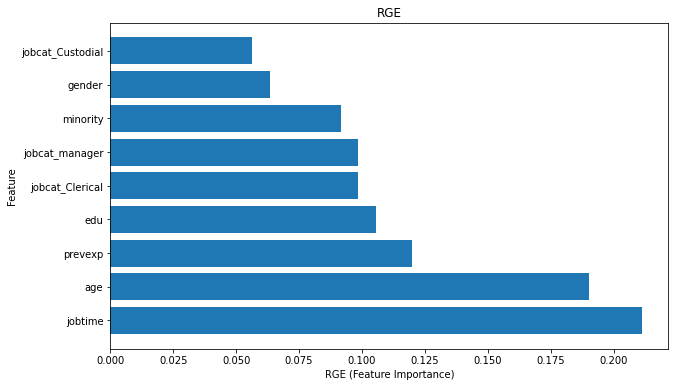

,RGE
jobtime,0.211268
age,0.190141
prevexp,0.119718
edu,0.105634
jobcat_Clerical,0.098592
jobcat_manager,0.098592
minority,0.091549
gender,0.063380
jobcat_Custodial,0.056338


In [14]:
explainability_obj.rge()

In [15]:
xtrain_jobtime = xtrain.drop("age", axis=1)
xtest_jobtime = xtest.drop("age", axis=1)
model_jobtime = RandomForestClassifier(random_state=1).fit(xtrain_jobtime, ytrain)
yhat_jobtime = model_jobtime.predict(xtest_jobtime)
modelagnostic_explainability.rge(yhat, yhat_jobtime)

0.1901408450704225

In [16]:
explainability_obj.rge_statistic_test("age")

4.317782439535485e-09

In [17]:
modelagnostic_explainability.rge_statistic_test(yhat, yhat_jobtime)

4.317782439535485e-09

# ROBUSTNESS

In [18]:
robustness_obj = robustness.Robustness(xtrain, xtest, ytrain, ytest, RandomForestClassifier(random_state=1))

In [19]:
robustness_obj.rgr_single("prevexp")

0.9084507042253521

In [20]:
## the following code lines are related to the perturbation process done in the safeaipackage 

traindata_ = xtrain.reset_index(drop=True)
perturbed_variable = traindata_.loc[:,"prevexp"]
vals = [[i, values] for i, values in enumerate(perturbed_variable)]
indices = [x[0] for x in sorted(vals, key= lambda item: item[1])]
sorted_variable = [x[1] for x in sorted(vals, key= lambda item: item[1])]
percentile_5_index = int(np.ceil(0.05 * len(sorted_variable)))
percentile_95_index = int(np.ceil((1-0.05) * len(sorted_variable)))
values_before_5th_percentile = sorted_variable[:percentile_5_index]
values_after_95th_percentile = sorted_variable[percentile_95_index:]
n = min([len(values_before_5th_percentile), len(values_after_95th_percentile)])
lowertail_indices = indices[0:n]
uppertail_indices = (indices[-n:])
uppertail_indices = uppertail_indices[::-1]
new_variable = perturbed_variable.copy()
for j in range(n):
    new_variable[lowertail_indices[j]] = perturbed_variable[uppertail_indices[j]]
    new_variable[uppertail_indices[j]] = perturbed_variable[lowertail_indices[j]]
traindata_.loc[:,"prevexp"] = new_variable

In [21]:
model_pert = RandomForestClassifier(random_state=1).fit(traindata_, ytrain)
yhat_pert = model_pert.predict(xtest)

modelagnostic_robustness.rgr(yhat, yhat_pert)

0.9084507042253521

In [22]:
robustness_obj.rgr_statistic_test("classification", LogisticRegression(random_state=1),"prevexp")

0.06519152511169134

In [23]:
model2 = LogisticRegression(random_state=1).fit(xtrain, ytrain)
yhat_mod2 = model2.predict(xtest)
model2_pert = LogisticRegression(random_state=1).fit(traindata_, ytrain)
yhat_mode2_pert = model2_pert.predict(xtest)

In [24]:
modelagnostic_robustness.rgr_statistic_test(yhat,yhat_mod2,yhat_pert,yhat_mode2_pert)

0.06519152511169134

# FAIRNESS

In [25]:
fairness_obj = fairness.Fairness(xtrain, xtest, ytrain, ytest, RandomForestClassifier(random_state=1))

In [26]:
fairness_obj.rgf(["gender"])

,RGF
gender,0.93662


In [27]:
xtrain_gender = xtrain.drop("gender", axis=1)
xtest_gender = xtest.drop("gender", axis=1)
model_gender = RandomForestClassifier(random_state=1).fit(xtrain_gender, ytrain)
yhat_gender = model_gender.predict(xtest_gender)
modelagnostic_fairness.rgf(yhat, yhat_gender)

0.9366197183098594

In [28]:
fairness_obj.rgf_statistic_test("gender")

0.0017927555084747172

In [29]:
modelagnostic_fairness.rgf_statistic_test(yhat, yhat_gender)

0.0017927555084747172

# PRIVACY

In [30]:
privacy_obj = privacy.Privacy(xtrain, xtest, ytrain, ytest, RandomForestClassifier(random_state=1))

In [31]:
privacy_obj.rgp([10, 12])

,RGP
10,0.943662
12,0.929577


In [32]:
xtrain.reset_index(drop=True, inplace=True)
ytrain.reset_index(drop=True, inplace=True)

xtrain_10 = xtrain.drop(10, axis=0)
ytrain_10 = ytrain.drop(10, axis=0)

model_10 = RandomForestClassifier(random_state=1).fit(xtrain_10, ytrain_10)
yhat_10 = model_10.predict(xtest)
modelagnostic_privacy.rgp(yhat, yhat_10)

0.9436619718309859

In [33]:
privacy_obj.rgp_statistic_test(10)

0.0034180095734045375

In [35]:
modelagnostic_privacy.rgp_statistic_test(yhat, yhat_10)

0.0034180095734045375